<a href="https://colab.research.google.com/github/1Pampu/BigData-ML-Proyectos/blob/main/TP2/Big_Data_TP2_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DATOS

*Análisis de Datos y Optimización de Modelos*

Este conjunto de bloques de código realiza diversas tareas relacionadas con análisis de datos y optimización de modelos. En primer lugar, se carga y preprocesa un conjunto de datos, eliminando columnas innecesarias con el fin de trabajar con datos mas limpios, reducir el ruido y centrarse en caracteristicas relevantes.

Luego se utiliza una visualización de relaciones entre características a través de gráficos de dispersión. La elección se debe a la necesidad de comprender mejor la estructura y las relaciones entre las características. Aunque esta visualización no proporcionó una imagen clara, se pudieron descartar algunas columnas no relevantes.

Además, se implementa la función "search_best_data" debido a la incertidumbre sobre la mejor combinación de columnas de características para los modelos. La función realiza una búsqueda de combinaciones (De las columnas del DataFrame) y optimización de hiperparámetros mediante búsqueda aleatoria (Random Search), registrando las mejores precisiones, combinaciones de columnas y modelos asociados. Es importante mencionar que esta función puede requerir un tiempo significativo para su ejecución, especialmente en función del modelo seleccionado.

En este proyecto, nuestro enfoque principal se centró en lograr el máximo puntaje en la validación cruzada. Con el objetivo de garantizar resultados sólidos y confiables, tambien se analizo la posibilidad de basarnos en los resultados del accuracy score pero los resultados fueron mejores o mas altos con la validacion cruzada, aqui la comparativa de los mejores resultados obtenidos de cada uno:

**Cross-Validation** VS **Accuracy**

KNN: 0.7009 - 0.6947

SVC: 0.6924 - 0.6963

~~DTC: 0.7186 - 0.7277~~ *(Varian mucho los resultados, poco confiable, no se tuvo en cuenta)*

GNB: 0.6775 - 0.6699

In [ ]:
# Import de bibliotecas necesarias
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from itertools import combinations
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

# Cargamos el dataset de canciones desde el archivo .CSV
df = pd.read_csv("Canciones_Spotify.csv")

# Eliminamos las columnas que no dan informacion relevante para un analisis
df = df.drop(columns=["song_title", "artist", "Unnamed: 0"])
df.head()

acousticness  danceability  duration_ms  energy  instrumentalness  key  \
0        0.0102         0.833       204600   0.434          0.021900    2   
1        0.1990         0.743       326933   0.359          0.006110    1   
2        0.0344         0.838       185707   0.412          0.000234    2   
3        0.6040         0.494       199413   0.338          0.510000    5   
4        0.1800         0.678       392893   0.561          0.512000    5   

   liveness  loudness  mode  speechiness    tempo  time_signature  valence  \
0    0.1650    -8.795     1       0.4310  150.062             4.0    0.286   
1    0.1370   -10.401     1       0.0794  160.083             4.0    0.588   
2    0.1590    -7.148     1       0.2890   75.044             4.0    0.173   
3    0.0922   -15.236     1       0.0261   86.468             4.0    0.230   
4    0.4390   -11.648     0       0.0694  174.004             4.0    0.904   

   target  
0       1  
1       1  
2       1  
3       1  
4       1

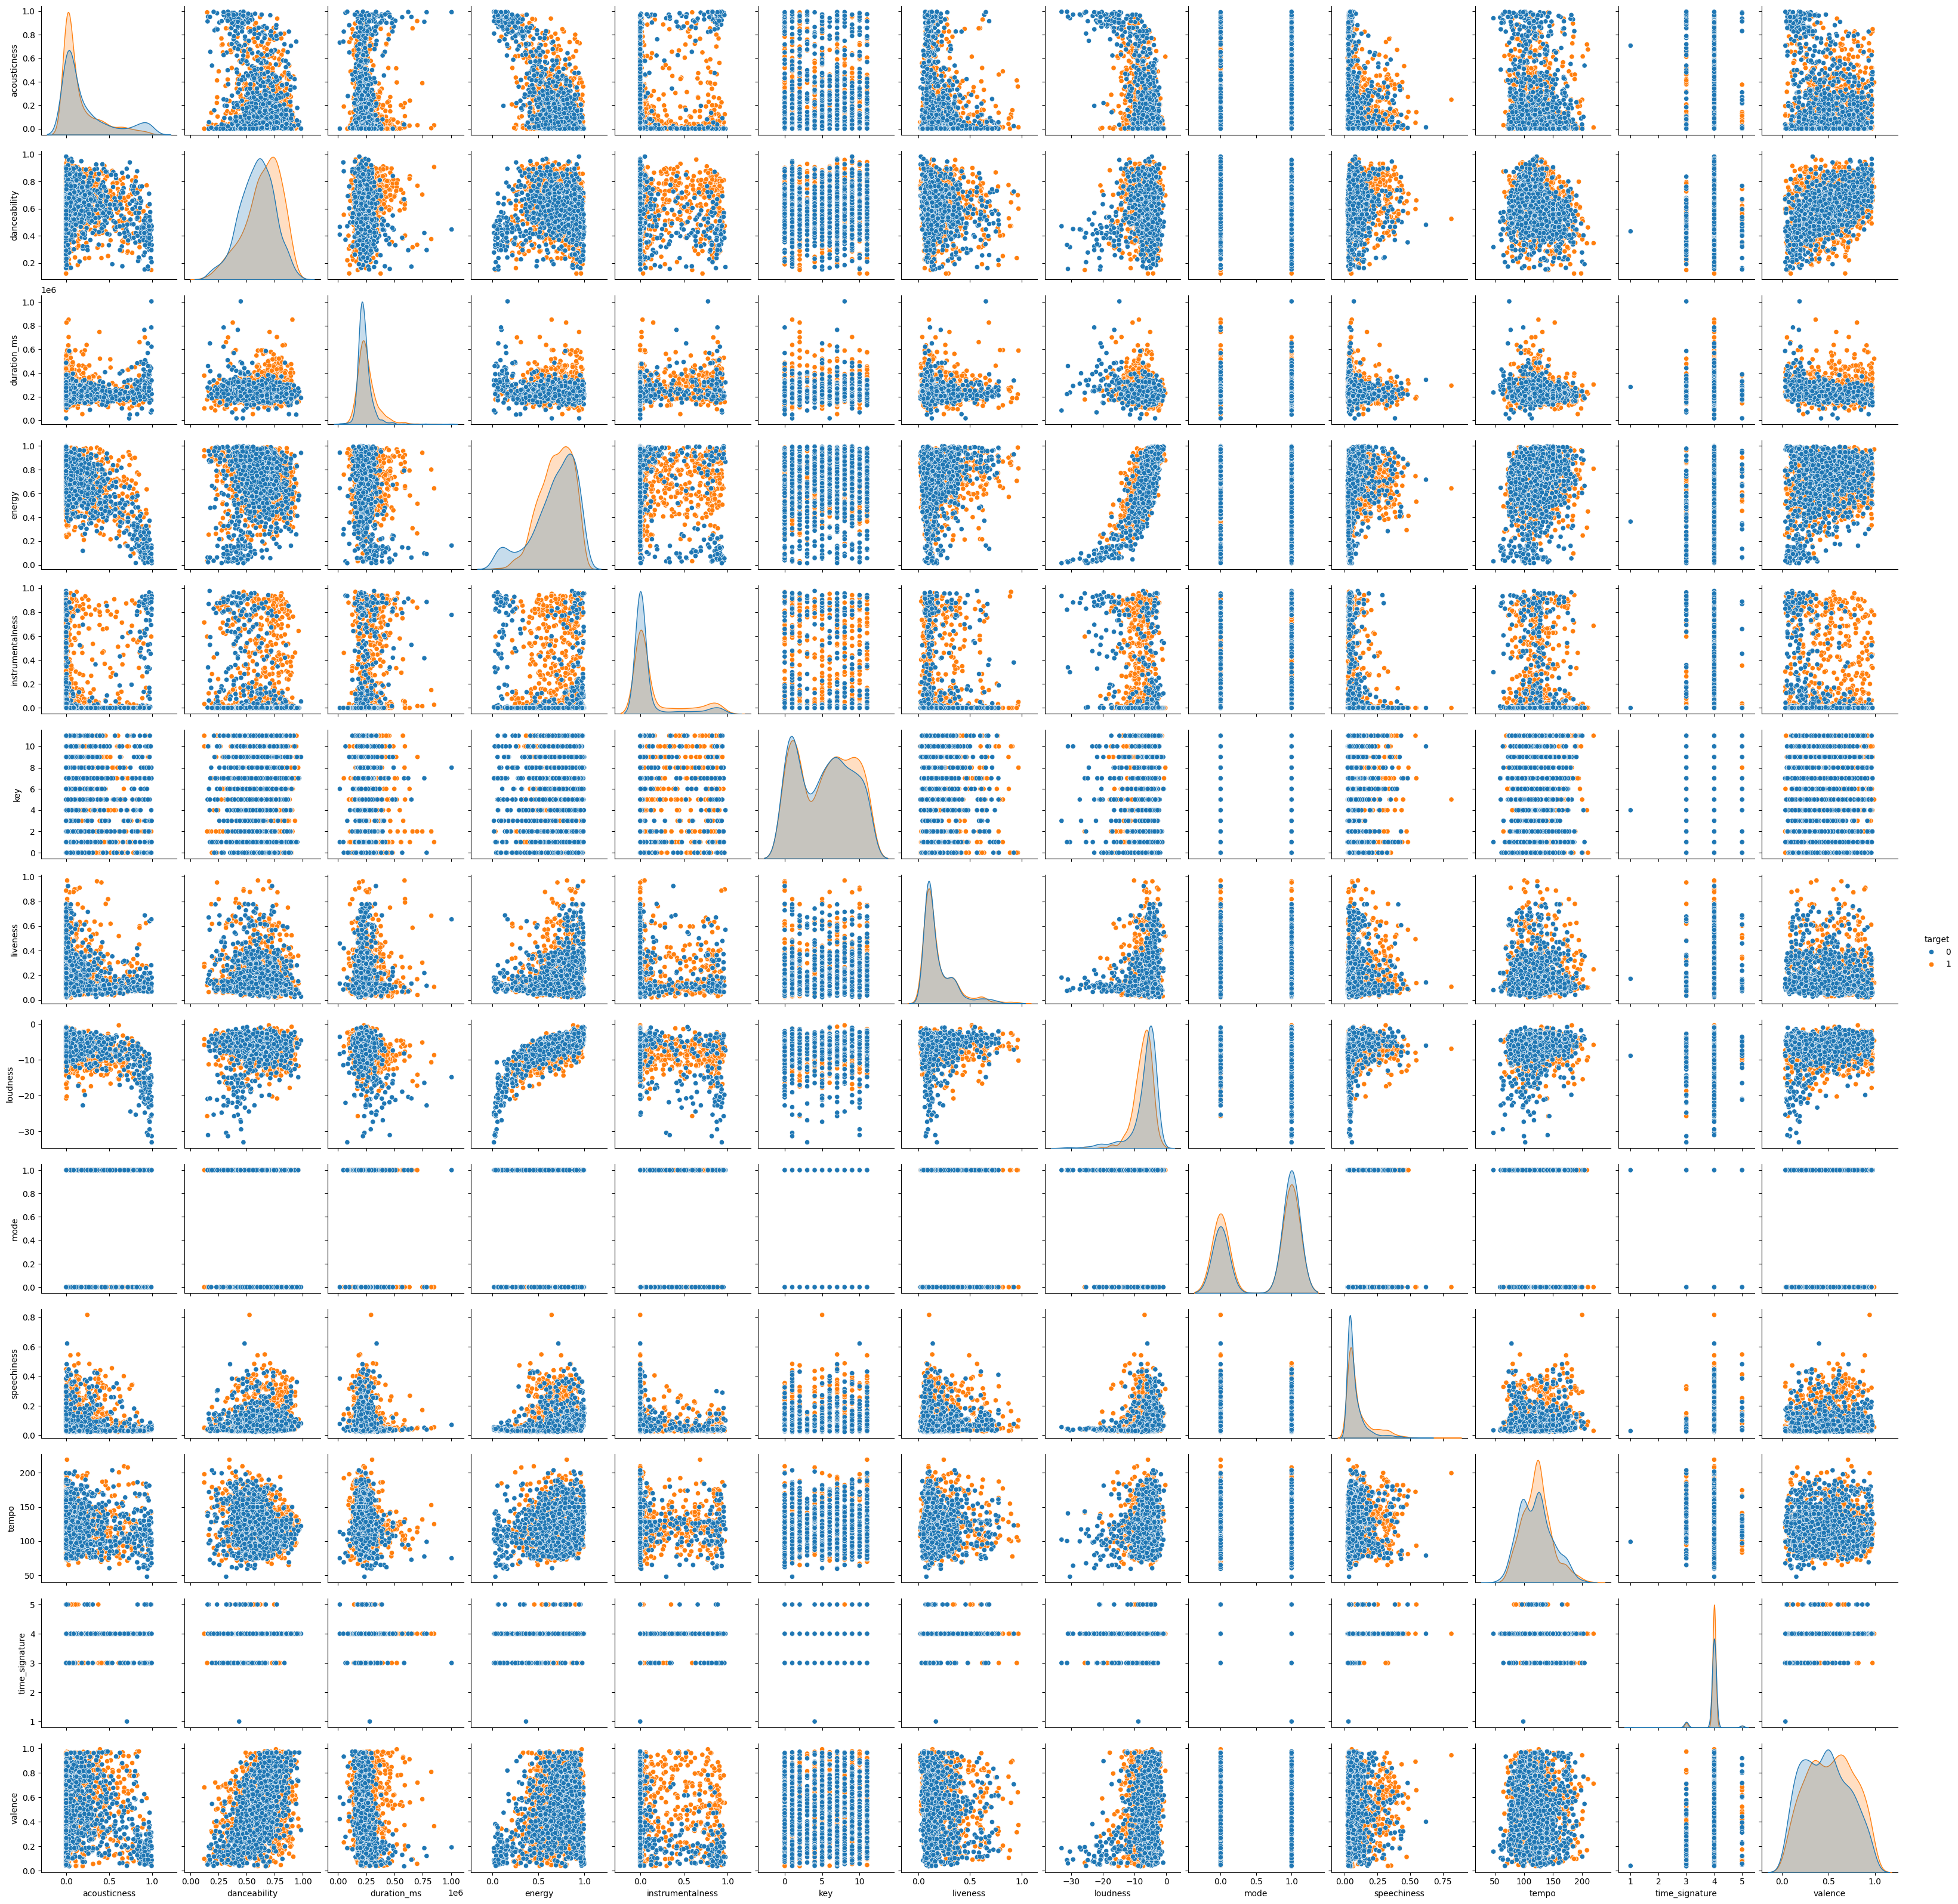

In [ ]:
# Creamos una matriz de graficos y mostramos los mismos
sns.pairplot(df, hue="target")
plt.show()

In [ ]:
# Eliminamos las columnas del DataFrame
df = df.drop(columns=["time_signature", "key", "duration_ms"])

# Creamos una variable "Y" que almacena la columna "target" del DataFrame y "X" que contiene las caracteristicas
Y = df["target"]
X = df.drop("target", axis=1)

# Separamos datos de prueba y entrenamiento
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 50)

In [ ]:
# Definimos de una función que busca la mejor combinación de columnas para el modelo recibido y con los mejores hiperparametros
def search_best_data(model, df, param_distributions):

    # Obtenemos el número de columnas en el DataFrame
    num_columns = X.shape[1]

    # Inicializamos variables para almacenar la mejor precisión, combinación de columnas y modelo ganador
    best_accuracy = 0
    best_columns_combination = None
    best_model = None

    # Iteramos a través de todas las combinaciones posibles de columnas
    for i in range(1, num_columns + 1):

        # Definimos las combinaciones de columnas posibles con un tamaño "i"
        columns_combination = combinations(X.columns, i)

        for combination in columns_combination:

            # Definimos la lista de columnas en la combinación actual
            selected_columns = list(combination)

            # Definimos el conjunto de columnas a utilizar en esta iteracion y separamos en datos de entrenamiento y prueba
            Xsub = X[selected_columns]
            X_train, _, y_train, _ = train_test_split(Xsub, Y, test_size=0.3, random_state=50)

            # Realizamos una búsqueda aleatoria de hiperparametros para el modelo (Con los parametros recibidos en la funcion)
            param_search = RandomizedSearchCV(model, param_distributions, n_iter=10, cv=5, scoring='accuracy', random_state=42)
            param_search.fit(X_train, y_train)
            score = param_search.best_score_

            # Actualizamos la mejor precisión y la mejor combinación si encontramos un puntaje mejor
            if score > best_accuracy:
                best_accuracy = score
                best_columns_combination = selected_columns
                best_model = param_search.best_estimator_

    # Devolvemos la mejor precisión, la mejor combinación de columnas y el modelo encontrado
    return best_accuracy, best_columns_combination, best_model

# KNN

*Análisis y Evaluación del Modelo KNN*

En estos bloques de código, llevamos a cabo un análisis y una evaluación del rendimiento del modelo KNN para la clasificación. Los parámetros utilizados, como el número de vecinos y la métrica de distancia, se basan en los resultados obtenidos previamente de la función "search_best_data," que buscó las configuraciones óptimas. Del mismo modo, las columnas seleccionadas para la construcción del modelo se derivan de la misma función, que identificó las características más relevantes para este modelo.

A lo largo de estos bloques de código, se evalúa el modelo KNN en términos de precisión, recuperación, puntaje F1 y se visualiza una matriz de confusión, lo que nos permite comprender el rendimiento.

Decidimos incluir una amplia gama de parámetros en la búsqueda aleatoria (Random Search) debido al  poco tiempo consume este proceso con el modelo seleccionado. Esta decisión se tomó en consideración de la eficiencia temporal y permitió explorar un espacio más amplio de hiperparámetros, acelerando el proceso de búsqueda de la configuración óptima del modelo.

Tuvimos que definir nuevamente la mejor combinacion de columnas en una celda aparte para poder ahorrarnos tener que ejecutar la funcion nuevamente, ya que como se explico anteriormente, requiere tiempo.

In [ ]:
# Creamos un modelo KNN
search_knn = KNeighborsClassifier()

# Definimos un diccionario que especifica las combinaciones de hiperparámetros a explorar
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 13, 15],
    'weights': ['uniform', 'distance'],
    'p': [1, 2],
    'algorithm': ['auto', 'ball_tree', 'kd_tree'],
    'leaf_size': [10, 20, 30, 40, 50]
}

# Llamamos a la función "search_best_data" con el modelo KNN, el DataFrame y el diccionario de hiperparámetros
best_score, best_combination, best_model = search_best_data(search_knn, df, param_grid)

# Imprimimos la mejor puntuación, la combinación de columnas, y el modelo correspondiente
print(f"Best Score: {best_score}")
print(f"Columns: {best_combination}")
print(f"Model: {best_model}")

Best Score: 0.7009322607322758
Columns: ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'mode', 'speechiness']
Model: KNeighborsClassifier(n_neighbors=11, p=1)


In [ ]:
# Redefinimos la lista que contiene el conjunto de columnas seleccionadas (Con el fin de no ejecutar la celda anterior nuevamente)
best_combination = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'mode', 'loudness','speechiness']

In [ ]:
# Creamos un modelo KNN con los parametros especificados por la función y entrenamos el modelo
knn = KNeighborsClassifier(n_neighbors = 11, p = 1)
knn.fit(X_train[best_combination], y_train)

# Realizamos una validación cruzada para evaluar el rendimiento del modelo
scores = cross_val_score(knn, X_train[best_combination], y_train, cv=5)
average_accuracy = scores.mean()
print("Validación Cruzada: {:.2f}%".format(average_accuracy * 100))

# Realizamos predicciones en el conjunto de prueba
knn_predictions = knn.predict(X_test[best_combination])

# Calculamos accuracy
accuracy = accuracy_score(y_test, knn_predictions)
print("Accuracy:", accuracy)

# Calculamos precision
precision = precision_score(y_test, knn_predictions)
print("Precision:", precision)

# Calculamos recall
recall = recall_score(y_test, knn_predictions)
print("Recall:", recall)

# Calculamos f1-score
f1 = f1_score(y_test, knn_predictions)
print("F1-score:", f1)

Validación Cruzada: 70.09%
Accuracy: 0.6551155115511551
Precision: 0.6893939393939394
Recall: 0.5889967637540453
F1-score: 0.6352530541012218


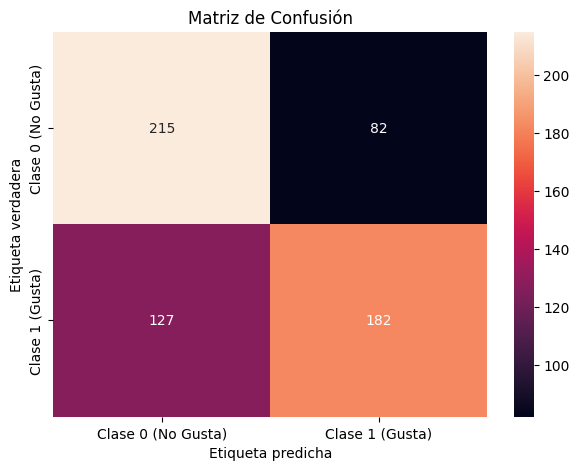

In [ ]:
# Se calcula una matriz de confusión
conf_matrix = confusion_matrix(y_test, knn_predictions)

# Se crea un gráfico que muestra la matriz con anotaciones de los valores y etiquetas
plt.figure(figsize=(7,5))
sns.heatmap(conf_matrix, annot=True, fmt='g', xticklabels=['Clase 0 (No Gusta)', 'Clase 1 (Gusta)'], yticklabels=['Clase 0 (No Gusta)', 'Clase 1 (Gusta)'])
plt.xlabel('Etiqueta predicha')
plt.ylabel('Etiqueta verdadera')
plt.title('Matriz de Confusión')

# Mostramos la visualización de la matriz de confusión
plt.show()

# SVC

*Análisis y Evaluación del Modelo SVC*

Iniciamos el bloque con la busqueda de columnas apropiadas para el modelo, en este caso se decidio usar menos parametros para el random grid a causa de el tiempo que tomaba cada iteracion de la funcion.

Asi que unicamente extraimos las columnas para luego realizar un Grid Search mas exhaustivo y la mayor cantidad de parametros posibles para el modelo que ya haya tenido el puntaje mas alto, de esa forma ajustamos los hiperparametros del modelo de forma mas eficiente y asi conseguimos mejorar el porcentaje de aciertos.

Al igual que el resto de los modelos, en una celda aparte definimos las columnas que retorno la funcion para ahorrarnos el tiempo.

Por lo que podemos deducir del analisis de la matriz de confusion podemos decir que este modelo en particular tiende mas a decir que no le gustan la mayoria de las canciones, por eso vemos que tiene mas errores cuando predice que una cancion no le gusta y en realidad si gusto. En cambio del otro lado vemos que en relacion se podria decir que cuando dice si le gusta tiende mas a tener razon.

In [ ]:
# Creamos un modelo SVC
search_svc = SVC()

# Definimos un diccionario que especifica las combinaciones de hiperparámetros a explorar
param_grid = {
    'kernel': ['linear', 'rbf', 'sigmoid'],
}

# Llamamos a la función "search_best_data" con el modelo SVC, el DataFrame y el diccionario de hiperparámetros
best_score, best_combination, best_model = search_best_data(search_svc, df, param_grid)

# Imprimimos la mejor puntuación, la combinación de columnas, y el modelo correspondiente
print(f"Best Score: {best_score}")
print(f"Columns: {best_combination}")
print(f"Model: {best_model}")

Best Score: 0.6924216224344033
Columns: ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'speechiness', 'valence']
Model: SVC()


In [ ]:
# Redefinimos la lista que contiene el conjunto de columnas seleccionadas (Con el fin de no ejecutar la celda anterior nuevamente)
best_combination = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'speechiness', 'valence']

In [ ]:
# Definimos un diccionario que especifica las combinaciones de hiperparámetros a explorar
param_grid = {
    'C': [0.1, 1, 10, 15],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'gamma': ['scale', 'auto', 0.1, 1, 10]
}

# Creamos un modelo SVC
grid_svc = SVC()

# Creamos un objeto GridSearch para la busqueda de parametros y ajustamos a los datos de entrenamiento
grid_search = GridSearchCV(grid_svc, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train[best_combination], y_train)

# Obtenemos los mejores hiperparametros encontrados
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Imprimimos el mejor modelo junto a su puntuacion
print("Model:", best_params)
print("Best Score:", best_score)

Model: {'C': 15, 'gamma': 'scale', 'kernel': 'rbf'}
Best Score: 0.7094228504122497


In [ ]:
# Creamos un modelo SVC con los parametros especificados por la GridSearch y entrenamos el modelo
svc = SVC(C = 15, gamma = "scale", kernel = "rbf")
svc.fit(X_train[best_combination], y_train)

# Realizamos una validación cruzada para evaluar el rendimiento del modelo
scores = cross_val_score(svc, X_train[best_combination], y_train, cv=5)
average_accuracy = scores.mean()
print("Validación Cruzada: {:.2f}%".format(average_accuracy * 100))

# Realizamos predicciones en el conjunto de prueba
svc_predictions = svc.predict(X_test[best_combination])

# Calculamos accuracy
accuracy = accuracy_score(y_test, svc_predictions)
print("Accuracy:", accuracy)

# Calculamos precision
precision = precision_score(y_test, svc_predictions)
print("Precision:", precision)

# Calculamos recall
recall = recall_score(y_test, svc_predictions)
print("Recall:", recall)

# Calculamos f1-score
f1 = f1_score(y_test, svc_predictions)
print("F1-score:", f1)

Validación Cruzada: 70.94%
Accuracy: 0.7128712871287128
Precision: 0.7566539923954373
Recall: 0.6440129449838188
F1-score: 0.6958041958041957


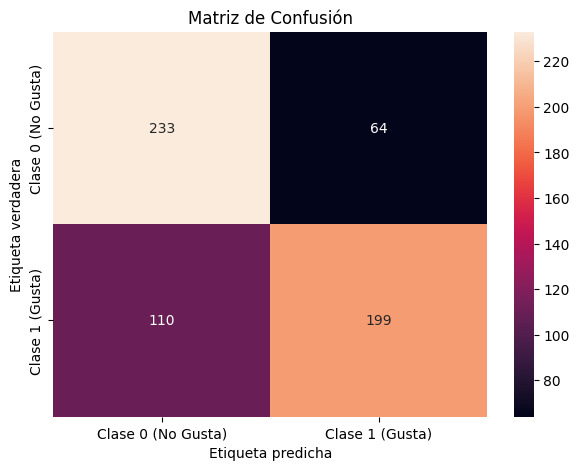

In [ ]:
# Se calcula una matriz de confusión
conf_matrix = confusion_matrix(y_test, svc_predictions)

# Se crea un gráfico que muestra la matriz con anotaciones de los valores y etiquetas
plt.figure(figsize=(7,5))
sns.heatmap(conf_matrix, annot=True, fmt='g', xticklabels=['Clase 0 (No Gusta)', 'Clase 1 (Gusta)'], yticklabels=['Clase 0 (No Gusta)', 'Clase 1 (Gusta)'])
plt.xlabel('Etiqueta predicha')
plt.ylabel('Etiqueta verdadera')
plt.title('Matriz de Confusión')

# Mostramos la visualización de la matriz de confusión
plt.show()

# DTC

*Análisis y Evaluación del Modelo DTC*

Iniciamos la implementacion de este modelo buscando las caracteristicas mas favorables para el mismo, utilizando la funcion previamente definida al inicio, esta vez con la mayor cantidad de hiperparametros posibles, realizando pruebas, nos dimos cuenta que este tipo de modelo no requiere casi tiempo para realizar el random search, por lo que nos deja incluir la cantidad de parametros que queramos.

Entrenamos el modelo con las especificaciones que retorno la funcion, igualmente se intento modificar los valores pero sin exito de mejora alguno. Es importante destacar que este modelo en particular genero muchas dudas a causa de su cambiante accuracy, en cada ejecucion todos los datos de rendimiento eran diferentes. A pesar de esta dificultad se puedo obtener un modelo que supera el 65% (De Accuracy) casi todas las ejecuciones, incluso a veces llegando a un 71%.

En la mayoria de sus ejecuciones este modelo los errores son bastante equilibardo en ambos casos, similar al modelo GNB. En ejecuciones particulares el modelo tendia mas a predecir que le gustan la cancion mas frecuentemente.

Luego de leer la documentacion a detalle, uno de los parametros a destacar fue el random_state, similar al utilizado en el split entre datos de prueba y testeo, con esto se soluciono la incosistencia de los resultados.

In [ ]:
# Creamos un modelo DTC
search_dtc = DecisionTreeClassifier()

# Definimos un diccionario que especifica las combinaciones de hiperparámetros a explorar
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2', None]
}

# Llamamos a la función "search_best_data" con el modelo DTC, el DataFrame y el diccionario de hiperparámetros
best_score, best_combination, best_model = search_best_data(search_dtc, df, param_grid)

# Imprimimos la mejor puntuación, la combinación de columnas, y el modelo correspondiente
print(f"Best Score: {best_score}")
print(f"Columns: {best_combination}")
print(f"Model: {best_model}")

Best Score: 0.7186201538731423
Columns: ['acousticness', 'danceability', 'energy', 'instrumentalness', 'loudness', 'tempo']
Model: DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features='log2', min_samples_leaf=2, min_samples_split=10)


In [ ]:
# Redefinimos la lista que contiene el conjunto de columnas seleccionadas (Con el fin de no ejecutar la celda anterior nuevamente)
best_combination = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'loudness', 'tempo']

In [ ]:
# Creamos un modelo DTC con los parametros especificados por la función y entrenamos el modelo
dtc = DecisionTreeClassifier(
    criterion = "entropy",
    max_depth = 10,
    max_features = "log2",
    min_samples_leaf = 2,
    min_samples_split = 10,
    random_state = 18)
dtc.fit(X_train[best_combination], y_train)

# Realizamos una validación cruzada para evaluar el rendimiento del modelo
scores = cross_val_score(dtc, X_train[best_combination], y_train, cv=5)
average_accuracy = scores.mean()
print("Validación Cruzada: {:.2f}%".format(average_accuracy * 100))

# Realizamos predicciones en el conjunto de prueba
dtc_predictions = dtc.predict(X_test[best_combination])

# Calculamos accuracy
accuracy = accuracy_score(y_test, dtc_predictions)
print("Accuracy: {:.2f}%".format(accuracy * 100))

# Calculamos precision
precision = precision_score(y_test, dtc_predictions)
print("Precision:", precision)

# Calculamos recall
recall = recall_score(y_test, dtc_predictions)
print("Recall:", recall)

# Calculamos f1-score
f1 = f1_score(y_test, dtc_predictions)
print("F1-score:", f1)

Validación Cruzada: 69.81%
Accuracy: 70.63%
Precision: 0.7364620938628159
Recall: 0.6601941747572816
F1-score: 0.6962457337883959


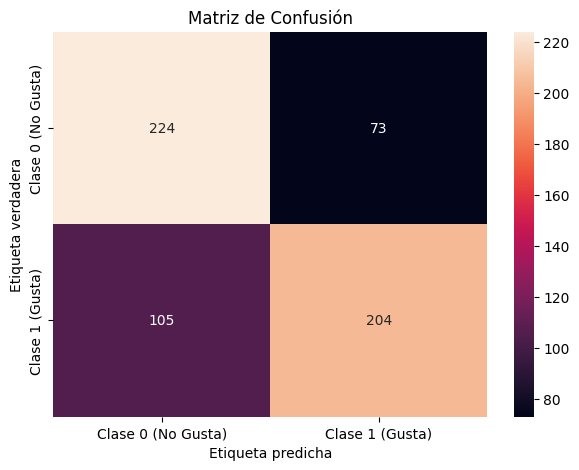

In [ ]:
# Se calcula una matriz de confusión
conf_matrix = confusion_matrix(y_test, dtc_predictions)

# Se crea un gráfico que muestra la matriz con anotaciones de los valores y etiquetas
plt.figure(figsize=(7,5))
sns.heatmap(conf_matrix, annot=True, fmt='g', xticklabels=['Clase 0 (No Gusta)', 'Clase 1 (Gusta)'], yticklabels=['Clase 0 (No Gusta)', 'Clase 1 (Gusta)'])
plt.xlabel('Etiqueta predicha')
plt.ylabel('Etiqueta verdadera')
plt.title('Matriz de Confusión')

# Mostramos la visualización de la matriz de confusión
plt.show()

# GNB

*Análisis y Evaluación del Modelo GNB*

A diferencia de el resto de los modelos implementados, este modelo no requiere un Random Search o Grid Search, esto no lo tuvimos en cuenta a la hora de implementar la funcion que busca las mejores caracteristicas e hiperparametros, por lo que nos vimos forzados a realizar una Random Search con el unico parametro que este modelo acepta.

Luego de probar la diferencia con y sin el parametro definido pudimos notar una diferencia, definitivamente anda mejor el modelo con el parametro que retorno la funcion por lo que fue de nuestro beneficio.

En cuanto al rendimiento de este modelo podemos decir que es el mas "Neutral", tiene casi la misma cantidad de aciertos que de errores en todas las posiciones de la matriz de confusion (En cuanto a los errores), es decir, a diferencia de los modelos KNN y SVC que tienden a equivocarse mas en ciertas circunstancias, este modelo parece que es bastante equilibrado en sus errores.

Es importante destacar que este modelo es con el que obtuvimos resultados mas bajos, excepto en algunas ejecuciones muy puntuales del modelo DTC, asi que se podria decir que es el menos "confiable" o no es muy adecuado para este caso particular.

In [ ]:
# Creamos un modelo GNB
search_gnb = GaussianNB()

# Definimos un diccionario que especifica las combinaciones de hiperparámetros a explorar
param_grid = {
    'var_smoothing': np.logspace(0, -9, num=100)
}

# Llamamos a la función "search_best_data" con el modelo GNB, el DataFrame y el diccionario de hiperparámetros
best_score, best_combination, best_model = search_best_data(search_gnb, df, param_grid)

# Imprimimos la mejor puntuación, la combinación de columnas, y el modelo correspondiente
print(f"Best Score: {best_score}")
print(f"Columns: {best_combination}")
print(f"Model: {best_model}")

Best Score: 0.6775430418765506
Columns: ['acousticness', 'danceability', 'instrumentalness', 'liveness', 'loudness', 'mode', 'speechiness', 'tempo']
Model: GaussianNB(var_smoothing=1.5199110829529332e-05)


In [ ]:
# Redefinimos la lista que contiene el conjunto de columnas seleccionadas (Con el fin de no ejecutar la celda anterior nuevamente)
best_combination = ['acousticness', 'danceability', 'instrumentalness', 'liveness', 'loudness', 'mode', 'speechiness', 'tempo']

In [ ]:
# Creamos un modelo GNB con los parametros especificados por la función y entrenamos el modelo
gnb = GaussianNB(var_smoothing=1.5199110829529332e-05)
gnb.fit(X_train[best_combination], y_train)

# Realizamos una validación cruzada para evaluar el rendimiento del modelo
scores = cross_val_score(gnb, X_train[best_combination], y_train, cv=5)
average_accuracy = scores.mean()
print("Validación Cruzada: {:.2f}%".format(average_accuracy * 100))

# Realizamos predicciones en el conjunto de prueba
gnb_predictions = gnb.predict(X_test[best_combination])

# Calculamos accuracy
accuracy = accuracy_score(y_test, gnb_predictions)
print("Accuracy:", accuracy)

# Calculamos precision
precision = precision_score(y_test, gnb_predictions)
print("Precision:", precision)

# Calculamos recall
recall = recall_score(y_test, gnb_predictions)
print("Recall:", recall)

# Calculamos f1-score
f1 = f1_score(y_test, gnb_predictions)
print("F1-score:", f1)

Validación Cruzada: 67.75%
Accuracy: 0.6303630363036303
Precision: 0.6366559485530546
Recall: 0.6407766990291263
F1-score: 0.6387096774193548


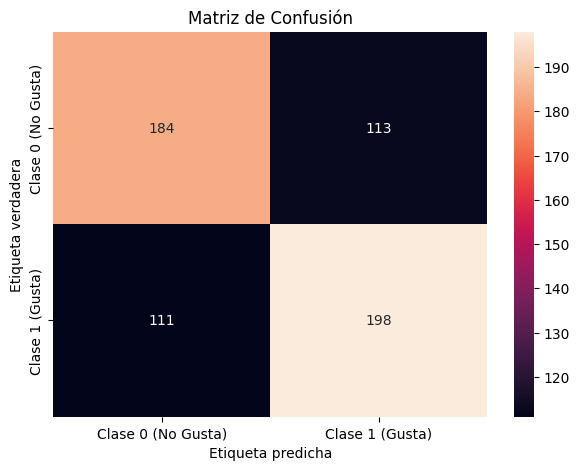

In [ ]:
# Se calcula una matriz de confusión
conf_matrix = confusion_matrix(y_test, gnb_predictions)

# Se crea un gráfico que muestra la matriz con anotaciones de los valores y etiquetas
plt.figure(figsize=(7,5))
sns.heatmap(conf_matrix, annot=True, fmt='g', xticklabels=['Clase 0 (No Gusta)', 'Clase 1 (Gusta)'], yticklabels=['Clase 0 (No Gusta)', 'Clase 1 (Gusta)'])
plt.xlabel('Etiqueta predicha')
plt.ylabel('Etiqueta verdadera')
plt.title('Matriz de Confusión')

# Mostramos la visualización de la matriz de confusión
plt.show()

# ENSAMBLE

*Análisis y Evaluación del Ensamble*

A la hora de implementar el ensamble nos dimos cuenta que para cada modelo estabamos separando los datos de prueba, por lo que primeramente los datos del ensamble eran incorrectos.

Luego de separar una unica vez los datos en datos de prueba y de testeo al inicio del notebook pudimos empezar a ver los verdaderos resultados del ensamble.

El ensamble no resulto mucho problema para la implementacion, pero los resutlados obtenidos por las pruebas de rendimiento no fueron las esperadas, se puede decir que el ensamble es un "promedio" de las predicciones recibidas de los modelos, pero esto no la hace mas exacta, realizando un conteo pudimos ver mejor esto.

Cantidad de **Errores**:

Ensamble: 187

KNN: 209

SVC: 174

DTC: 178 *(Llegó a 220 en ejecuciones con random_state aleatorio)*

GNB: 224

Es destacable la diferencia notable de los modelos SVC y DTC (Varia mucho igualmente sin el random state) con respecto a el resto de los modelos, teniendo menos de 25 errores que el resto de modelos.

In [ ]:
# Inicializamos una variable para almacenar las predicciones finales
final_predictions = []

# Iteramos a traves de las predicciones de los modelos entrenados
for knn, svc, gnb, dtc in zip(knn_predictions,svc_predictions,gnb_predictions, dtc_predictions):

    # Creamos un diccionario para almacenar los votos de cada modelo
    votes = {0: 0, 1: 0}

    # Incrementamos los votos para cada clase basados en las predicciones de cada modelo
    votes[knn] += 1
    votes[svc] += 1
    votes[gnb] += 1
    votes[dtc] += 1

    # Encontramos la prediccion con el mayor numero de votos
    majority_vote = max(votes, key=votes.get)

    # Agregamos la prediccion a la lista final de predicciones
    final_predictions.append(majority_vote)

In [ ]:
# Calculamos accuracy
accuracy = accuracy_score(y_test, final_predictions)
print("Accuracy:", accuracy)

# Calculamos precision
precision = precision_score(y_test, final_predictions)
print(f'Precision: {precision}')

# Calculamos recall
recall = recall_score(y_test, final_predictions)
print(f'Recall: {recall}')

# Calculamos f1-score
f1 = f1_score(y_test, final_predictions)
print(f'F1-score: {f1}')

Accuracy: 0.6914191419141914
Precision: 0.7652173913043478
Recall: 0.56957928802589
F1-score: 0.653061224489796


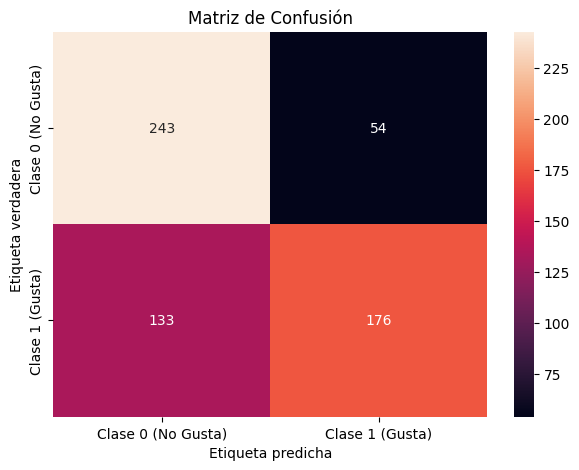

In [ ]:
# Se calcula una matriz de confusión
conf_matrix = confusion_matrix(y_test, final_predictions)

# Se crea un gráfico que muestra la matriz con anotaciones de los valores y etiquetas
plt.figure(figsize=(7,5))
sns.heatmap(conf_matrix, annot=True, fmt='g', xticklabels=['Clase 0 (No Gusta)', 'Clase 1 (Gusta)'], yticklabels=['Clase 0 (No Gusta)', 'Clase 1 (Gusta)'])
plt.xlabel('Etiqueta predicha')
plt.ylabel('Etiqueta verdadera')
plt.title('Matriz de Confusión')

# Mostramos la visualización de la matriz de confusión
plt.show()